# Banking Fraud with various Predictions

## Setup

Import AWS specific modules and specify S3 data location

In [1]:
# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install --upgrade seaborn
# !{sys.executable} -m pip install --upgrade imbalanced-learn
import boto3
import os
from random import seed, sample
import sagemaker
import sagemaker.amazon.amazon_estimator
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer

Import python ML modules

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set_context("paper")

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
# from xgboost.sklearn import XGBClassifier

In [3]:
bucket = 'sagemaker-pmelvin'
prefix = 'compile_xgb_v3'
hp_prefix = 'hp_tuning_v3'

csv_data = 'input-data/bb_banking_fraud.csv'
csv_removed_types = 'input-data/removed-specific-types/01a89090-e9b6-4b07-8a49-b0244d6dc035.csv'
full_data_location = 's3://{}/{}'.format(bucket, csv_data)
clean_data_location = 's3://{}/{}'.format(bucket, csv_removed_types)

#local_file = 'bb_banking_fraud.csv'

role = get_execution_role()
sess = sagemaker.Session()
smclient = boto3.Session().client('sagemaker')

## Data

In [4]:
%%time
df_full = pd.read_csv(full_data_location)

CPU times: user 9.86 s, sys: 2.23 s, total: 12.1 s
Wall time: 24.9 s


In [5]:
# %%time
# df_clean = pd.read_csv(clean_data_location)

In [7]:
df_u = df_full.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest', 'isfraud':'isFraud'})

In [10]:
df_u_copy = df_u.copy()

df_u['hourOfDay'] = np.nan
df_u.hourOfDay = df_u_copy.step % 24

In [11]:
first_col = df_u.pop('isFraud')
df_u.insert(0, 'isFraud', first_col)

In [12]:
df_u.head()

In [16]:
sample = df_u.sample(n=10000, random_state=42)

In [19]:
def get_features(df):
    
    selected_cols = [
        'type', 'amount', 'oldBalanceOrig', 'newBalanceOrig',
        'oldBalanceDest', 'newBalanceDest', 'isFraud', 'hourOfDay'
    ]
    
    df = df[selected_cols].copy()
    dummies = pd.get_dummies(df.type)
    df = pd.concat([df, dummies], axis=1).drop("type", axis=1)
    
    return df

In [20]:
def reduce_data(pca_df):
    pca_df = pca_df.copy()
    target = pca_df.pop("isFraud")
    scaler = StandardScaler()
    pca_df = scaler.fit_transform(pca_df)
    pca = PCA(n_components=2)
    components = pca.fit_transform(pca_df)

    comp_df = pd.DataFrame(components, columns=["X", "y"])
    target = target.reset_index(drop=True)
    plot_df = pd.concat([comp_df, target], axis=1)
    
    return plot_df

In [21]:
# def fraud_plot(plot_df, maj_alpha=0.5, min_alpha=1, save=None):
#     fig, ax = plt.subplots(figsize=(8, 6))
#     ax = sns.scatterplot(x="X", y="y", alpha=maj_alpha, data=plot_df[plot_df.isFraud == 0], label="Legitimate")
#     sns.scatterplot(x="X", y="y", alpha=min_alpha, data=plot_df[plot_df.isFraud == 1], ax=ax, label="Fraud")
#     plt.title("Legitimate vs Fraudulent Purchases")
#     plt.tight_layout()
#     if save != None:
#         plt.savefig(save)
#     plt.show()
    
#     pass

In [ ]:
# processed_data = get_features(sample)
# plot_df = reduce_data(processed_data)
# fraud_plot(plot_df)

In [23]:
# processed_data.shape

In [24]:
# processed_data.head(n=5)

In [25]:
from imblearn.under_sampling import RandomUnderSampler
RUS = RandomUnderSampler(sampling_strategy={0: 9589}, random_state=42)

In [27]:
def resample(df, method):
    processed_df = get_features(df)
    target = processed_df.pop('isFraud')

    processed_x, processed_y = method.fit_resample(processed_df, target)

    cols = list(processed_df.columns) + ["isFraud"]

    pdf_x = pd.DataFrame(processed_x, columns=processed_df.columns)
    pdf_y = pd.DataFrame(processed_y, columns=['isFraud'])
    resampled_df = pd.concat([pdf_x, pdf_y], axis=1)
    
    return resampled_df

In [ ]:
%%time
rus_resampled = resample(df_u, RUS)
# print(rus_resampled.shape)
# print(rus_resampled.isFraud.value_counts())

In [ ]:
# fraud_plot(reduce_data(rus_resampled), min_alpha=0.5)

In [30]:
# from imblearn.over_sampling import SMOTE
# SM = SMOTE(random_state=42)

In [ ]:
# %%time
# sm_resampled = resample(df_u, SM)
# print(sm_resampled.shape)
# print(sm_resampled.isFraud.value_counts())

In [33]:
# sm_sample = sm_resampled.sample(n=10000, random_state=42)
# fraud_plot(reduce_data(sm_sample), min_alpha=0.5)


## Splitting and standardising

In [36]:
first_col = rus_resampled.pop('isFraud')
rus_resampled.insert(0, 'isFraud', first_col)

In [ ]:
rus_resampled.shape

In [37]:
rus_resampled.head()

,isFraud,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,hourOfDay,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,183806.32,19391.00,0.00,382572.19,566378.51,18,0,1,0,0,0
1,0,521.37,0.00,0.00,0.00,0.00,17,0,0,0,1,0
2,0,3478.18,19853.00,16374.82,0.00,0.00,11,0,0,0,1,0
3,0,1716.05,5769.17,4053.13,0.00,0.00,19,0,0,0,1,0
4,0,253129.93,1328499.49,1581629.42,2713220.48,2460090.55,18,1,0,0,0,0


In [40]:
X = rus_resampled.drop('isFraud', 1)
y = rus_resampled.isFraud

We will split the dataset with a 80% for training, 15% for validation and 5% for testing data

In [43]:
train_ratio = 0.80
validation_ratio = 0.15
test_ratio = 0.05

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state=42, shuffle=True, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42, shuffle=True, stratify=y) 

print('split train: {}, val: {}, test: {} '.format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

split train: 14241, val: 2670, test: 891 


In [45]:
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()

scaler.fit(X_train)

MinMaxScaler()

In [47]:
#
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
X_test  = pd.DataFrame(scaler.fit_transform(X_test),columns = X_test.columns)
X_val   = pd.DataFrame(scaler.fit_transform(X_val),columns = X_val.columns)

In [48]:
#
X_train_ins = X_train.copy()
X_test_ins  = X_test.copy()
X_val_ins   = X_val.copy()

X_train_ins.insert(0, 'isFraud', y_train.values)
X_test_ins.insert(0, 'isFraud', y_test.values)
X_val_ins.insert(0, 'isFraud', y_val.values)

In [49]:
#
X_train.to_csv('train.csv', index=False, header=False)
X_val.to_csv('validation.csv', index=False, header=False)

# Save test and baseline with headers
X_test.to_csv('test.csv', index=False, header=True)
X_train.to_csv('baseline.csv', index=False, header=True)

In [50]:
#
# convert to numpy arrays for later use
X_train = X_train.to_numpy()
X_test  = X_test.to_numpy()
X_val   = X_val.to_numpy()

In [56]:
pl_prefix = 'pipeline'

s3_train_uri = sess.upload_data('train.csv', bucket, pl_prefix + '/data/training')
print('Uploaded training data location: {}'.format(s3_train_uri))

s3_val_uri = sess.upload_data('validation.csv', bucket, pl_prefix + '/data/validation')
print('Uploaded validation data location: {}'.format(s3_val_uri))

s3_baseline_uri = sess.upload_data('baseline.csv', bucket, pl_prefix + '/data/baseline')
print('Uploaded validation data location: {}'.format(s3_baseline_uri))

s3_output_location = 's3://{}/{}/output'.format(bucket, pl_prefix)
print('Training artifacts will be uploaded to: {}'.format(s3_output_location))

Uploaded training data location: s3://sagemaker-pmelvin/pipeline/data/training/train.csv
Uploaded validation data location: s3://sagemaker-pmelvin/pipeline/data/validation/validation.csv
Uploaded validation data location: s3://sagemaker-pmelvin/pipeline/data/baseline/baseline.csv
Training artifacts will be uploaded to: s3://sagemaker-pmelvin/pipeline/output


In [57]:
s3_input_train = sagemaker.inputs.TrainingInput("s3://{}/{}/{}/".format(bucket, pl_prefix, 'data/training'), content_type='text/csv')
s3_input_validation = sagemaker.inputs.TrainingInput("s3://{}/{}/{}/".format(bucket, pl_prefix, 'data/validation'), content_type='text/csv')

In [58]:
xgboost_container = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, '1.0-1')

In [59]:
instance_type='ml.m5.xlarge'

hyperparameters = {
        "alpha":"0.2",
        "max_depth":"10",
        "eta":"0.12",
        "gamma":"2.0",
        "min_child_weight":"8.5",
        "subsample":"0.6",
        "objective":"binary:logistic",
        "num_round":"20",
        "eval_metric":"auc"
        }

In [60]:
smote_xgb = sagemaker.estimator.Estimator(image_uri=xgboost_container,
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(), 
                                          instance_count=1, 
                                          instance_type=instance_type,
                                          output_path=s3_output_location,
                                          sagemaker_session=sess)

In [ ]:
%%time
smote_xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

# use if you only want to train and not validate
# smote_xgb.fit({'train': s3_input_train})

In [62]:
%%time
deploy_instance_type='ml.m5.large'
smote_predictor = smote_xgb.deploy(initial_instance_count=1,
                                   model_name="xgb-smote-model-02",
                                   endpoint_name="xgb-smote-endpoint-02",
                                   instance_type=deploy_instance_type,
                                   serializer=CSVSerializer(),
                                   deserializer=None)

---------------!CPU times: user 214 ms, sys: 9.93 ms, total: 223 ms
Wall time: 7min 32s


In [63]:
# use if already deployed

# endpoint_name = "xgb-smote-endpoint-02"
# smote_predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

Once we have trained the model we can use it to make predictions for the test dataset

In [64]:
def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [65]:
%%time
smote_raw_predictions = predict(smote_predictor, X_test[:, 1:])

CPU times: user 24.2 ms, sys: 2.73 ms, total: 27 ms
Wall time: 210 ms


In [66]:
smote_binary_predictions = np.where(smote_raw_predictions > 0.5, 1, 0)

In [67]:
%%time
y_train_preds = predict(smote_predictor, X_train[:, 1:])

CPU times: user 219 ms, sys: 4.16 ms, total: 223 ms
Wall time: 942 ms


In [68]:
%%time
y_valid_preds = predict(smote_predictor, X_val[:, 1:])

CPU times: user 45.5 ms, sys: 4.36 ms, total: 49.9 ms
Wall time: 171 ms


In [69]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)

    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print(' ')
    return auc, accuracy, recall, precision, specificity

Now, let's have a look at our results

In [70]:
thresh = 0.1

# print('XGBoost Classifier')
print('Training:')
xgb_train_auc, xgb_train_accuracy, xgb_train_recall, xgb_train_precision, xgb_train_specificity = print_report(y_train, y_train_preds, thresh)

print('Validation:')
xgb_valid_auc, xgb_valid_accuracy, xgb_valid_recall, xgb_valid_precision, xgb_valid_specificity = print_report(y_val, y_valid_preds, thresh)

XGBoost Classifier
Training:
AUC:0.767
accuracy:0.683
recall:0.332
precision:0.939
specificity:0.982
 
Validation:
AUC:0.752
accuracy:0.688
recall:0.388
precision:0.884
specificity:0.955
 


Now let's have a look at the confusion matrix

In [71]:
def plot_confusion_matrix(y_test, y_pred):

    cm  = confusion_matrix(y_test, y_pred)
    # Get the per-class normalized value for each cell
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # We color each cell according to its normalized value, annotate with exact counts.
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d", cmap="Blues")
    ax.set(xticklabels=["non-fraud", "fraud"], yticklabels=["non-fraud", "fraud"])
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')
    plt.ylabel('Real Label')
    plt.xlabel('Predicted Label')
    plt.show()

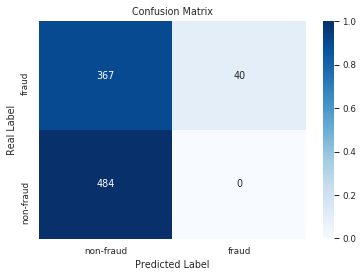

In [72]:
# plot_confusion_matrix(y_test, smote_binary_predictions)
plot_confusion_matrix(y_test, smote_binary_predictions)

and now let's have a look at a ROC curve

AUC is 0.7674


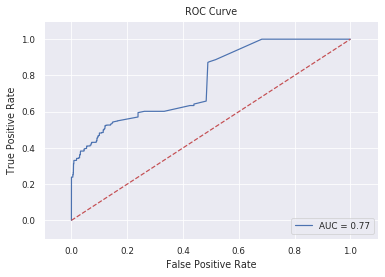

In [73]:
from sklearn import metrics

auc = round(roc_auc_score(y_train, y_train_preds), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_train, y_train_preds)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


and finally we need to clean up all our resources

In [85]:
smote_predictor.delete_model()
smote_predictor.delete_endpoint()
sm_client = boto3.client('sagemaker', region_name=boto3.Session().region_name)
waiter = sm_client.get_waiter('endpoint_deleted')
waiter.wait(EndpointName="xgb-smote-endpoint-02")